# **Identificación de Imágenes Auténticas y Sintéticas : Abordando los Desafíos de las Imágenes Sintéticas en la Sociedad Actual**

**Contenido**
1. [Configuración del Entorno](#title1)
2. [Construcción del Conjunto de Datos](#title2)
3. [Creación del Modelo](#title3)

## Configuración del Entorno<a name="title1"></a>

In [1]:
import tensorflow as tf
print(tf.config.experimental.list_physical_devices("GPU"))
print(tf.__version__)
# Para limitar la memoria que usa la GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar TensorFlow para que solo utilice la GPU si es necesario
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Configuración de GPU completada")
    except RuntimeError as e:
        print(e)
# Verifica que la GPU está disponible
print("¿GPU está disponible?:", tf.config.list_physical_devices('GPU'))
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import gc
import tensorflow as tf
from keras import backend as K

# Limpiar la memoria del backend
K.clear_session()
# Forzar la recolección de basura
gc.collect()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0
Configuración de GPU completada
¿GPU está disponible?: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


0

In [2]:
# Limpiar la memoria del backend
K.clear_session()
# Forzar la recolección de basura
gc.collect()

105

In [2]:
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

## Construcción del Conjunto de Datos y Preprocesandolos<a name="title2"></a>

Fuente: https://www.kaggle.com/datasets/kaustubhdhote/human-faces-dataset & https://www.kaggle.com/datasets/hamzaboulahia/hardfakevsrealfaces/code

In [3]:


dataset_path = './Human Faces Dataset'
real_images_path = os.path.join(dataset_path, 'Real Images')
ai_generated_images_path = os.path.join(dataset_path, 'AI-Generated Images')

output_path = './kaggle/working/'
train_path = os.path.join(output_path, 'train')
val_path = os.path.join(output_path, 'val')
test_path = os.path.join(output_path, 'test')

for path in [train_path, val_path, test_path]:
    os.makedirs(os.path.join(path, 'Real Images'), exist_ok=True)
    os.makedirs(os.path.join(path, 'AI-Generated Images'), exist_ok=True)

train_split = 0.7
val_split = 0.15
test_split = 0.15

def split_and_copy_images(source_dir, dest_dirs, split_ratios):
    images = os.listdir(source_dir)
    random.shuffle(images)
    
    train_size = int(len(images) * split_ratios[0])
    val_size = int(len(images) * split_ratios[1])
    
    for i, img in enumerate(images):
        if i < train_size:
            dest_dir = dest_dirs[0]
        elif i < train_size + val_size:
            dest_dir = dest_dirs[1]
        else:
            dest_dir = dest_dirs[2]
            
        shutil.copy(os.path.join(source_dir, img), os.path.join(dest_dir, img))

split_and_copy_images(real_images_path, [os.path.join(train_path, 'Real Images'), os.path.join(val_path, 'Real Images'), os.path.join(test_path, 'Real Images')], [train_split, val_split, test_split])
split_and_copy_images(ai_generated_images_path, [os.path.join(train_path, 'AI-Generated Images'), os.path.join(val_path, 'AI-Generated Images'), os.path.join(test_path, 'AI-Generated Images')], [train_split, val_split, test_split])

In [4]:


img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 7642 images belonging to 2 classes.
Found 1637 images belonging to 2 classes.
Found 1640 images belonging to 2 classes.


# Modelo<a name="title3"></a>



In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [6]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
239/239 [==============================] - 23s 73ms/step - loss: 0.5276 - accuracy: 0.7694 - val_loss: 0.3865 - val_accuracy: 0.8754
Epoch 2/10
239/239 [==============================] - 16s 68ms/step - loss: 0.3260 - accuracy: 0.8880 - val_loss: 0.2751 - val_accuracy: 0.9071
Epoch 3/10
239/239 [==============================] - 16s 68ms/step - loss: 0.2606 - accuracy: 0.9032 - val_loss: 0.2092 - val_accuracy: 0.9334
Epoch 4/10
239/239 [==============================] - 16s 68ms/step - loss: 0.2109 - accuracy: 0.9266 - val_loss: 0.1920 - val_accuracy: 0.9224
Epoch 5/10
239/239 [==============================] - 16s 68ms/step - loss: 0.1888 - accuracy: 0.9300 - val_loss: 0.1558 - val_accuracy: 0.9560
Epoch 6/10
239/239 [==============================] - 16s 68ms/step - loss: 0.1544 - accuracy: 0.9498 - val_loss: 0.1343 - val_accuracy: 0.9646
Epoch 7/10
239/239 [==============================] - 16s 68ms/step - loss: 0.1356 - accuracy: 0.9562 - val_loss: 0.1260 - val_accuracy:

52/52 [==============================] - 3s 55ms/step - loss: 0.0948 - accuracy: 0.9671
Test Loss: 0.09479409456253052
Test Accuracy: 0.9670731425285339
52/52 [==============================] - 3s 53ms/step
                     precision    recall  f1-score   support

AI-Generated Images       0.49      0.48      0.49       801
        Real Images       0.51      0.52      0.52       839

           accuracy                           0.50      1640
          macro avg       0.50      0.50      0.50      1640
       weighted avg       0.50      0.50      0.50      1640

Confusion Matrix
[[387 414]
 [404 435]]


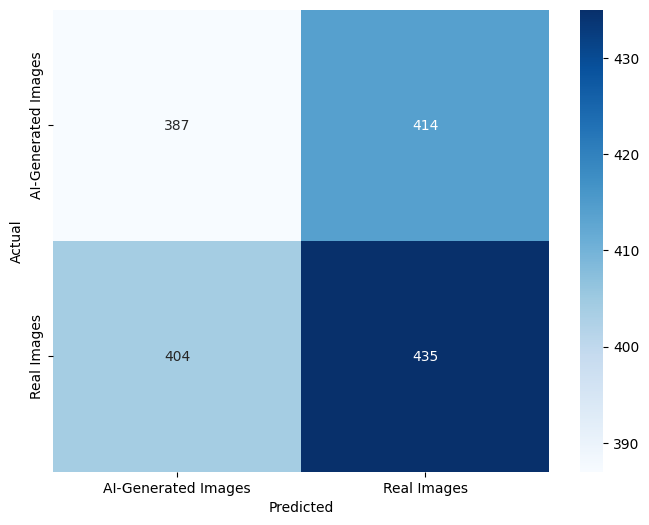

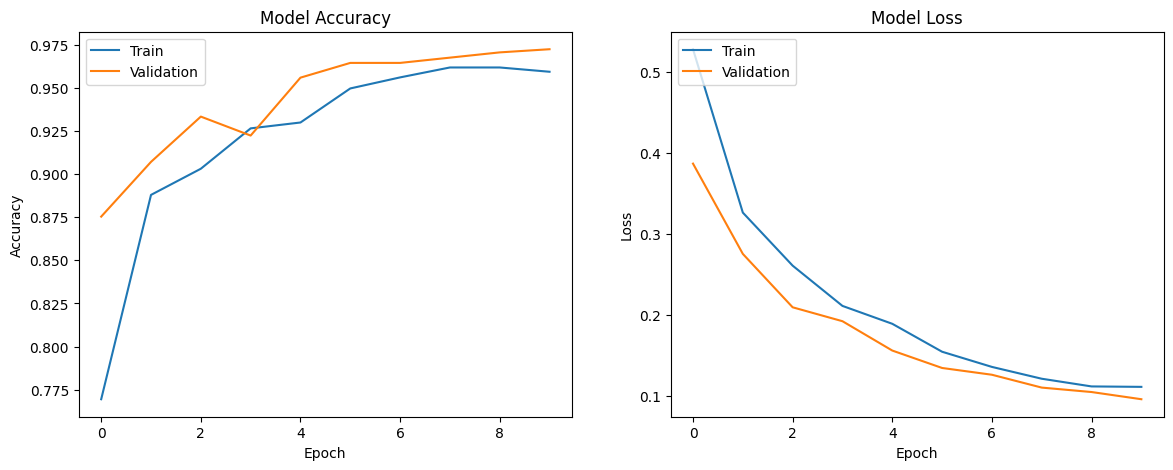

In [7]:
# Evaluating the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generating predictions
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix")
print(cm)

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Plot training history
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()